In [40]:
import pandas as pd
import nltk
from nltk import classify
from nltk import NaiveBayesClassifier
from nltk.corpus import twitter_samples
import multiprocessing as mp
import fds_utils as utils
import importlib
_ = importlib.reload(utils)
import random
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# downloads a small dataset of pre-labeled tweets (positive and negative) from the NLTK library.
nltk.download('twitter_samples')


# Preparing Model Train Data
Normalizing is done as in the PreProcessing.ipynb <br>
Other steps are also based on the tutorial.

In [42]:
# loads tokenized positive tweets
positive_tokens = twitter_samples.tokenized('positive_tweets.json')
# loads tokenized negative tweets
negative_tokens = twitter_samples.tokenized('negative_tweets.json')

Normalization is done using your own utils.normalize function, which:

Lemmatizes words

Removes stopwords and links

Converts all tokens to a consistent form

In [43]:
with mp.Pool(mp.cpu_count()) as pool:
    # This may return a generator in some environments, so we wrap with list()
    positive_tokens_normal = list(pool.map(utils.normalize, positive_tokens))
    negative_tokens_normal = list(pool.map(utils.normalize, negative_tokens))

In [44]:
print(positive_tokens_normal[:3])
print(negative_tokens_normal[:3])

[['#followfriday', '@france_inte', '@pkuchly57', '@milipol_paris', 'top', 'engage', 'member', 'community', 'week', ':)'], ['@lamb2ja', 'hey', 'james', 'odd', ':/', 'please', 'call', 'contact', 'centre', '02392441234', 'able', 'assist', ':)', 'many', 'thanks'], ['@despiteofficial', 'listen', 'last', 'night', ':)', 'bleed', 'amazing', 'track', 'scotland']]
[['hopeless', 'tmr', ':('], ['everything', 'kid', 'section', 'ikea', 'cute', 'shame', 'nearly', '19', '2', 'month', ':('], ['@hegelbon', 'heart', 'slide', 'waste', 'basket', ':(']]


In [45]:
# Tokens must be put into a dictionary for the model
positive_tokens_normal = list(utils.transform_for_model(positive_tokens_normal))
negative_tokens_normal = list(utils.transform_for_model(negative_tokens_normal))

In [46]:
# Prepare dataset for training
positive_dataset = [(tweet_dict, "Positive") for tweet_dict in positive_tokens_normal]
negative_dataset = [(tweet_dict, "Negative") for tweet_dict in negative_tokens_normal]

#print(positive_dataset)
#print(negative_dataset)

In [47]:
#Combine & Shuffle Data
dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

# 70:30 ratio
train_data = dataset[:7000]
test_data = dataset[7000:]

In [48]:
# Train Naive Bayes Classifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.996
Most Informative Features
                      :( = True           Negati : Positi =   2050.5 : 1.0
                      :) = True           Positi : Negati =   1664.9 : 1.0
                     sad = True           Negati : Positi =     23.7 : 1.0
                 welcome = True           Positi : Negati =     22.8 : 1.0
                     bam = True           Positi : Negati =     21.2 : 1.0
                     x15 = True           Negati : Positi =     18.8 : 1.0
                follower = True           Positi : Negati =     18.7 : 1.0
                followed = True           Negati : Positi =     16.9 : 1.0
                    damn = True           Negati : Positi =     14.9 : 1.0
                     via = True           Positi : Negati =     12.4 : 1.0
None


In [49]:
from nltk.classify import accuracy

# Accuracy on training data
train_accuracy = accuracy(classifier, train_data)
print("Train accuracy:", train_accuracy)

# Accuracy on test data
test_accuracy = accuracy(classifier, test_data)
print("Test accuracy:", test_accuracy)


Train accuracy: 0.9995714285714286
Test accuracy: 0.996


In [50]:
f = open('classifier.pkl', 'wb')
pickle.dump(classifier, f)
f.close()

# Twitter Sentiment Analysis: Predicting Sentiment for Each Tweet
Analyzing sentiment for each tweet lets us measure and compare the overall positivity or negativity of online discussions about the candidates.

In [51]:
# load the data
us_tweets = pd.read_pickle('data/tweets_sample_normalized.pkl')


In [52]:
# Check Date Column:
us_tweets['date'] = pd.to_datetime(us_tweets['date'], errors='coerce')
print(us_tweets['date'].min(), us_tweets['date'].max())


2016-08-12 00:00:00 2016-09-12 00:00:00


In [53]:
# Feature Transformation: we convert the list of tokens for each tweet into a dictionary format required by NLTK’s Naive Bayes classifier
def transform_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

tweet_features = list(transform_for_model(us_tweets['tokens_normal']))


In [54]:
# Sentiment Prediction
us_tweets['predicted_sentiment'] = [classifier.classify(feats) for feats in tweet_features]


In [55]:
us_tweets.head(10)


,date,text,lang,country,city,tokens,tokens_normal,predicted_sentiment
0,2016-08-12,@theblaze @realDonaldTrump https://t.co/TY9DlZ...,und,United States,Frontenac,"[@theblaze, @realDonaldTrump, https://t.co/TY9...","[@theblaze, @realdonaldtrump]",Negative
1,2016-08-12,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,en,United States,Baton Rouge,"[@BarackObama, @FBI, @LORETTALYNCH, ALL, IN, C...","[@barackobama, @fbi, @lorettalynch, collusion,...",Positive
2,2016-08-12,@theblaze @realDonaldTrump https://t.co/n050DB...,und,United States,Frontenac,"[@theblaze, @realDonaldTrump, https://t.co/n05...","[@theblaze, @realdonaldtrump]",Negative
3,2016-08-12,#CNN #newday clear #Trump deliberately throwin...,en,United States,Baltimore,"[#CNN, #newday, clear, #Trump, deliberately, t...","[#cnn, #newday, clear, #trump, deliberately, t...",Negative
4,2016-08-12,"@realDonaldTrump, you wouldn't recognize a lie...",en,United States,Palm Springs,"[@realDonaldTrump, ,, you, wouldn't, recognize...","[@realdonaldtrump, recognize, lie, come, mouth...",Negative
5,2016-08-12,"""Kid, you know, suing someone? Thats the most ...",en,United States,Secaucus,"["", Kid, ,, you, know, ,, suing, someone, ?, T...","[kid, know, sue, someone, thats, beautiful, th...",Positive
6,2016-08-12,@HillaryClinton you ARE the co-founder of ISIS...,en,United States,Irving,"[@HillaryClinton, you, ARE, the, co-founder, o...","[@hillaryclinton, co-founder, isis, crook, evi...",Negative
7,2016-08-12,@mike4193496 @realDonaldTrump I TOTALLY CONCUR...,en,United States,Chesapeake Beach,"[@mike4193496, @realDonaldTrump, I, TOTALLY, C...","[@mike4193496, @realdonaldtrump, totally, conc...",Positive
8,2016-08-12,@realDonaldTrump @elsolarverde What issues? Yo...,en,United States,Battle Creek,"[@realDonaldTrump, @elsolarverde, What, issues...","[@realdonaldtrump, @elsolarverde, issue, idiot...",Negative
9,2016-08-12,Can't stand @HillaryClinton or @realDonaldTrum...,en,United States,Middletown,"[Can't, stand, @HillaryClinton, or, @realDonal...","[can't, stand, @hillaryclinton, @realdonaldtru...",Negative


# Topic Modelling


Topic modeling is an unsupervised machine learning technique that automatically finds groups of words (topics) that frequently occur together in a large collection of text. It helps summarize the main themes or subjects present in the data, so we can quickly understand what people are talking about, even without reading every tweet or document. Each topic is described by its most important words, and each tweet/document gets a score for how strongly it relates to each topic. With this we will be able to see which topics are related for both candidates and we will be able to separate them on two groups for the polls comparison.

In [80]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize tweets
vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
X = vectorizer.fit_transform(us_tweets['text'])

# Topic Modeling
nmf = NMF(n_components=5, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

# Show top words for each topic
for topic_idx, topic in enumerate(H):
    print(f"Topic {topic_idx}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])


Topic 0:
['https', 'imwithher', 'nevertrump', 'neverhillary', 'maga', 'trumppence16', 'donaldtrump', 'crookedhillary', 'fuckyoudonald', 'trumptrain']
Topic 1:
['hillaryclinton', 'foxnews', 'potus', 'cnn', 'hfa', 'onmessageforher', 'amp', 'timkaine', 'rogerjstonejr', 'realkingrobbo']
Topic 2:
['realdonaldtrump', 'foxnews', 'fuckyoudonald', 'cnn', 'seanhannity', 'kellyannepolls', 'mike_pence', 'don', 'nytimes', 'yes']
Topic 3:
['orchard', 'crab', 'forecast', '2016', 'rain', 'temp', 'wind', 'pressure', 'ky', 'today']
Topic 4:
['trump', 'hillary', 'amp', 'vote', 'maga', 'like', 'don', 'people', 'just', 'nevertrump']


# Compare Twitter Sentiment with Polls
We compare Twitter sentiment scores to official poll results over time in order to explore whether online public opinion, as expressed on social media, reflects or anticipates trends observed in traditional polling data. This comparison helps us assess the relationship and potential predictive power of Twitter sentiment with respect to actual voter preferences.


### Initial analysis on the poll data

In [57]:
# here we load the poll data
polls = pd.read_csv('data/presidential_polls.csv')
print(polls.columns)
polls.head(5)

Index(['cycle', 'branch', 'type', 'matchup', 'forecastdate', 'state',
       'startdate', 'enddate', 'pollster', 'grade', 'samplesize', 'population',
       'poll_wt', 'rawpoll_clinton', 'rawpoll_trump', 'rawpoll_johnson',
       'rawpoll_mcmullin', 'adjpoll_clinton', 'adjpoll_trump',
       'adjpoll_johnson', 'adjpoll_mcmullin', 'multiversions', 'url',
       'poll_id', 'question_id', 'createddate', 'timestamp'],
      dtype='object')


,cycle,branch,type,matchup,forecastdate,state,startdate,enddate,pollster,grade,...,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,multiversions,url,poll_id,question_id,createddate,timestamp
0,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,U.S.,10/25/2016,10/31/2016,Google Consumer Surveys,B,...,42.64140,40.86509,5.675099,NaN,NaN,https://datastudio.google.com/u/0/#/org//repor...,47940,74999,11/1/16,15:09:38 1 Nov 2016
1,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,U.S.,10/27/2016,10/30/2016,ABC News/Washington Post,A+,...,43.29659,44.72984,3.401513,NaN,NaN,http://www.langerresearch.com/wp-content/uploa...,47881,74936,11/1/16,15:09:38 1 Nov 2016
2,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,Virginia,10/27/2016,10/30/2016,ABC News/Washington Post,A+,...,46.29779,40.72604,6.401513,NaN,NaN,https://www.washingtonpost.com/local/virginia-...,47880,74934,11/1/16,15:09:38 1 Nov 2016
3,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,Florida,10/20/2016,10/24/2016,SurveyUSA,A,...,46.35931,45.30585,1.777730,NaN,NaN,http://www.baynews9.com/content/news/baynews9/...,47465,74252,10/25/16,15:09:38 1 Nov 2016
4,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,U.S.,10/20/2016,10/25/2016,Pew Research Center,B+,...,45.32744,42.20888,3.618320,NaN,NaN,http://www.people-press.org/2016/10/27/as-elec...,47616,74519,10/27/16,15:09:38 1 Nov 2016


In [58]:
polls.describe()

,cycle,samplesize,poll_wt,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,poll_id,question_id
count,10236.0,10233.000000,10236.000000,10236.000000,10236.000000,6480.000000,51.000000,10236.000000,10236.000000,6480.000000,51.000000,10236.000000,10236.000000
mean,2016.0,1115.791557,0.221769,41.717579,39.227002,7.713394,23.235294,43.024900,42.048617,4.804207,24.877707,45317.883060,70588.462485
std,0.0,2159.610968,0.535846,7.482747,7.648679,2.948387,7.278979,6.732445,6.707382,2.492364,5.710113,2871.251404,4677.283414
min,2016.0,35.000000,0.000000,11.040000,4.000000,0.000000,9.000000,16.419590,3.233949,-3.372429,13.973230,35362.000000,47244.000000
25%,2016.0,440.000000,0.000444,38.000000,34.877500,6.000000,20.000000,40.151210,37.973375,3.321972,21.407520,44850.750000,68747.000000
50%,2016.0,772.000000,0.008206,43.000000,39.000000,7.250000,26.000000,43.732560,42.034530,4.502154,26.093830,45925.500000,71773.500000
75%,2016.0,1225.000000,0.101939,46.000000,44.000000,9.000000,29.000000,46.507035,45.373783,5.855422,29.672160,47008.250000,73497.750000
max,2016.0,40816.000000,7.591351,88.000000,68.000000,25.000000,31.000000,86.699620,71.864600,19.277800,31.982120,48000.000000,75067.000000


In [59]:
polls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10236 entries, 0 to 10235
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cycle             10236 non-null  int64  
 1   branch            10236 non-null  object 
 2   type              10236 non-null  object 
 3   matchup           10236 non-null  object 
 4   forecastdate      10236 non-null  object 
 5   state             10236 non-null  object 
 6   startdate         10236 non-null  object 
 7   enddate           10236 non-null  object 
 8   pollster          10236 non-null  object 
 9   grade             9102 non-null   object 
 10  samplesize        10233 non-null  float64
 11  population        10236 non-null  object 
 12  poll_wt           10236 non-null  float64
 13  rawpoll_clinton   10236 non-null  float64
 14  rawpoll_trump     10236 non-null  float64
 15  rawpoll_johnson   6480 non-null   float64
 16  rawpoll_mcmullin  51 non-null     float6

In [60]:
print(polls.shape)
print(polls.nunique())


(10236, 27)
cycle                   1
branch                  1
type                    3
matchup                 1
forecastdate            1
state                  57
startdate             345
enddate               338
pollster              188
grade                  10
samplesize           1589
population              4
poll_wt              6255
rawpoll_clinton      1179
rawpoll_trump        1254
rawpoll_johnson       540
rawpoll_mcmullin       10
adjpoll_clinton     10197
adjpoll_trump       10188
adjpoll_johnson      5527
adjpoll_mcmullin       33
multiversions           1
url                  1156
poll_id              3412
question_id          3412
createddate           215
timestamp               3
dtype: int64


In [61]:
# Parse enddate as datetime (if not already)
polls['enddate'] = pd.to_datetime(polls['enddate'])

# Compute the daily mean of adjusted poll numbers for each candidate on which we have tweets
daily_polls = polls.groupby('enddate')[['adjpoll_clinton', 'adjpoll_trump']].mean().reset_index()

# Rename 'enddate' to 'date' for merging convenience
daily_polls.rename(columns={'enddate': 'date'}, inplace=True)

### Data Preparation
This section go through the process of data preparation for the creation of the sentiment vs. polls graph

We Separate the tweets for the two Candidates based on the topics from the topic modelling. Then we calculate proportions of positive and Negative tweets for both candidates


In [99]:
# Define sets with popular words
trump_keywords = {
    'trump', 'donald', 'trumppence16', 'trumptrain', 'trump2016', 'teamtrump', 'don'
    'nevertrump', 'realdonaldtrump', 'donaldtrump', 'maga'
}

clinton_keywords = {
    'clinton', 'hillary', 'hillaryclinton', 'crookedhillary',
    'imwithher', 'onmessageforher', 'neverhillary',
}

# functions that will collect tweets for the relavant topics
def is_trump(tokens):
    tokens_set = set(tokens)
    # Trump if any trump_keywords are present, and not any clinton_keywords
    return bool(trump_keywords & tokens_set) and not bool(clinton_keywords & tokens_set)

def is_clinton(tokens):
    tokens_set = set(tokens)
    # Clinton if any clinton_keywords are present, and not any trump_keywords
    return bool(clinton_keywords & tokens_set) and not bool(trump_keywords & tokens_set)

# apply yhe functions
us_tweets['for_trump'] = us_tweets['tokens_normal'].apply(is_trump)
us_tweets['for_clinton'] = us_tweets['tokens_normal'].apply(is_clinton)

# divide the tweets into two groups
trump_tweets = us_tweets[us_tweets['for_trump']]
clinton_tweets = us_tweets[us_tweets['for_clinton']]



In [100]:
print(trump_tweets.shape)
print(clinton_tweets.shape)

(50834, 10)
(28599, 10)


This section visualizes the proportion of positive and negative tweets about Hillary Clinton and Donald Trump using a side-by-side bar chart.

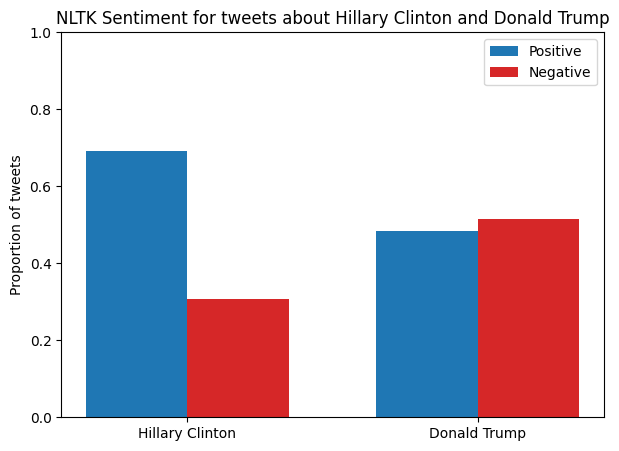

In [101]:
# Calculate Proportions
# For Clinton
clinton_total = len(clinton_tweets)
# Proportion of Clinton tweets predicted as Positive
clinton_pos = (clinton_tweets['predicted_sentiment'] == 'Positive').sum() / clinton_total
# Proportion of Clinton tweets predicted as Negative
clinton_neg = (clinton_tweets['predicted_sentiment'] == 'Negative').sum() / clinton_total

# For Trump
trump_total = len(trump_tweets)
# Proportion of Trump tweets predicted as Positive
trump_pos = (trump_tweets['predicted_sentiment'] == 'Positive').sum() / trump_total
# Proportion of Trump tweets predicted as Negative
trump_neg = (trump_tweets['predicted_sentiment'] == 'Negative').sum() / trump_total

# Prepare for Plotting
labels = ['Hillary Clinton', 'Donald Trump']
positive = [clinton_pos, trump_pos]   # from earlier code
negative = [clinton_neg, trump_neg]

x = np.arange(len(labels))  # the label locations
width = 0.35                # width of the bars

fig, ax = plt.subplots(figsize=(7,5))
# Draw blue and red bars for positive sentiment and sentiment
rects1 = ax.bar(x - width/2, positive, width, label='Positive', color='tab:blue')
rects2 = ax.bar(x + width/2, negative, width, label='Negative', color='tab:red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Proportion of tweets')
ax.set_title('NLTK Sentiment for tweets about Hillary Clinton and Donald Trump')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()

plt.show()

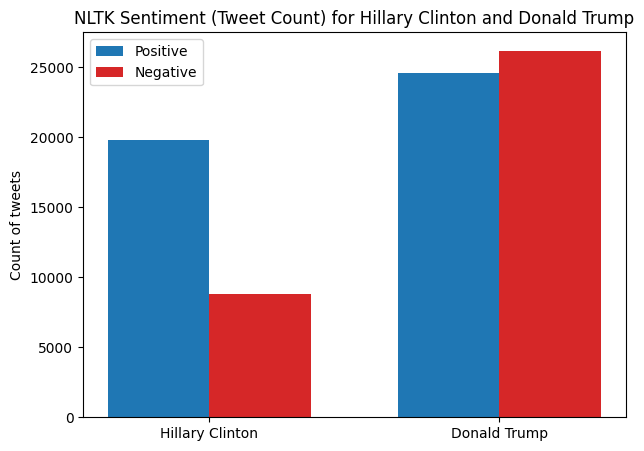

In [102]:
# Calculate Counts
# For Clinton
clinton_pos_count = (clinton_tweets['predicted_sentiment'] == 'Positive').sum()
clinton_neg_count = (clinton_tweets['predicted_sentiment'] == 'Negative').sum()

# For Trump
trump_pos_count = (trump_tweets['predicted_sentiment'] == 'Positive').sum()
trump_neg_count = (trump_tweets['predicted_sentiment'] == 'Negative').sum()

# Prepare for Plotting
labels = ['Hillary Clinton', 'Donald Trump']
positive = [clinton_pos_count, trump_pos_count]
negative = [clinton_neg_count, trump_neg_count]

x = np.arange(len(labels))  # the label locations
width = 0.35                # width of the bars

fig, ax = plt.subplots(figsize=(7,5))
# Draw blue and red bars for positive and negative sentiment counts
rects1 = ax.bar(x - width/2, positive, width, label='Positive', color='tab:blue')
rects2 = ax.bar(x + width/2, negative, width, label='Negative', color='tab:red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count of tweets')
ax.set_title('NLTK Sentiment (Tweet Count) for Hillary Clinton and Donald Trump')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


In [103]:
trump_tweets.head(5)

,date,text,lang,country,city,tokens,tokens_normal,predicted_sentiment,for_trump,for_clinton
7,2016-08-12,@mike4193496 @realDonaldTrump I TOTALLY CONCUR...,en,United States,Chesapeake Beach,"[@mike4193496, @realDonaldTrump, I, TOTALLY, C...","[@mike4193496, @realdonaldtrump, totally, conc...",Positive,True,False
8,2016-08-12,@realDonaldTrump @elsolarverde What issues? Yo...,en,United States,Battle Creek,"[@realDonaldTrump, @elsolarverde, What, issues...","[@realdonaldtrump, @elsolarverde, issue, idiot...",Negative,True,False
11,2016-08-12,"GOP pleading w Trump ""Just control your behavi...",en,United States,Colorado,"[GOP, pleading, w, Trump, "", Just, control, yo...","[gop, plead, w, trump, control, behavior, week...",Negative,True,False
29,2016-08-12,Trump is an insult to democracy. Tweet to defe...,en,United States,Manhattan,"[Trump, is, an, insult, to, democracy, ., Twee...","[trump, insult, democracy, tweet, defeat, @rea...",Negative,True,False
30,2016-08-12,"Dear Trump,\nWe're not nearly as strange as yo...",en,United States,Salt Lake City,"[Dear, Trump, ,, We're, not, nearly, as, stran...","[dear, trump, nearly, strange, jackass, care, ...",Positive,True,False


In [104]:
clinton_tweets.head(5)

,date,text,lang,country,city,tokens,tokens_normal,predicted_sentiment,for_trump,for_clinton
12,2016-08-12,@HillaryClinton ISIS co-founder Hillary Clinto...,en,United States,Irving,"[@HillaryClinton, ISIS, co-founder, Hillary, C...","[@hillaryclinton, isis, co-founder, hillary, c...",Positive,False,True
14,2016-08-12,@HFA @HillaryClinton wake up Dems Hillary is c...,en,United States,Irving,"[@HFA, @HillaryClinton, wake, up, Dems, Hillar...","[@hfa, @hillaryclinton, wake, dems, hillary, c...",Positive,False,True
17,2016-08-12,@realDonaldTrump Is yr crazy performance due ...,en,United States,Vallejo,"[@realDonaldTrump, Is, yr, crazy, performance,...","[@realdonaldtrump, yr, crazy, performance, due...",Negative,False,True
86,2016-08-12,@livenewscloud @elizabethforma @realDonaldTrum...,en,United States,Arkansas,"[@livenewscloud, @elizabethforma, @realDonaldT...","[@livenewscloud, @elizabethforma, @realdonaldt...",Positive,False,True
97,2016-08-12,@realDonaldTrump layoff of the Obama and Hilla...,en,United States,Altus,"[@realDonaldTrump, layoff, of, the, Obama, and...","[@realdonaldtrump, layoff, obama, hillary, tra...",Positive,False,True


This section analyzes and computes the daily sentiment trend for Trump and Clinton tweets by calculating a sentiment score for each date.

In [105]:
# Group tweets by date and count occurrences of each sentiment
# Compute the net sentiment score for each day:
# (Positive tweets - Negative tweets) / (Total tweets that day)
# For Trump
trump_by_day = trump_tweets.groupby('date')['predicted_sentiment'].value_counts().unstack().fillna(0)
trump_by_day['predicted_sentiment'] = (trump_by_day['Positive'] - trump_by_day['Negative']) / (trump_by_day['Positive'] + trump_by_day['Negative'])

# For Clinton
clinton_by_day = clinton_tweets.groupby('date')['predicted_sentiment'].value_counts().unstack().fillna(0)
clinton_by_day['predicted_sentiment'] = (clinton_by_day['Positive'] - clinton_by_day['Negative']) / (clinton_by_day['Positive'] + clinton_by_day['Negative'])

trump_by_day = trump_by_day.reset_index()
clinton_by_day = clinton_by_day.reset_index()

print(trump_by_day)
print(clinton_by_day)

predicted_sentiment       date  Negative  Positive  predicted_sentiment
0                   2016-08-12       688       703             0.010784
1                   2016-08-13       819       803            -0.009864
2                   2016-08-14       849       863             0.008178
3                   2016-08-15       895       863            -0.018203
4                   2016-08-16       656       705             0.036003
5                   2016-08-17      1007       986            -0.010537
6                   2016-08-18       681       650            -0.023291
7                   2016-08-19      1103      1069            -0.015654
8                   2016-08-20       902       785            -0.069354
9                   2016-08-21       721       675            -0.032951
10                  2016-08-22       819       670            -0.100067
11                  2016-08-23       904       740            -0.099757
12                  2016-08-24       746       690            -0

In [106]:
polls[['state',
       'startdate', 'enddate', 'grade', 'samplesize', 'population',
       'poll_wt', 'rawpoll_clinton', 'rawpoll_trump', 'adjpoll_clinton', 'adjpoll_trump',
       'createddate', 'timestamp']]

,state,startdate,enddate,grade,samplesize,population,poll_wt,rawpoll_clinton,rawpoll_trump,adjpoll_clinton,adjpoll_trump,createddate,timestamp
0,U.S.,10/25/2016,2016-10-31,B,24316.0,lv,6.139129,37.69,35.07,42.64140,40.86509,11/1/16,15:09:38 1 Nov 2016
1,U.S.,10/27/2016,2016-10-30,A+,1128.0,lv,4.197292,45.00,46.00,43.29659,44.72984,11/1/16,15:09:38 1 Nov 2016
2,Virginia,10/27/2016,2016-10-30,A+,1024.0,lv,3.876856,48.00,42.00,46.29779,40.72604,11/1/16,15:09:38 1 Nov 2016
3,Florida,10/20/2016,2016-10-24,A,1251.0,lv,3.403096,48.00,45.00,46.35931,45.30585,10/25/16,15:09:38 1 Nov 2016
4,U.S.,10/20/2016,2016-10-25,B+,2120.0,rv,3.394646,46.00,40.00,45.32744,42.20888,10/27/16,15:09:38 1 Nov 2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10231,Alabama,9/30/2016,2016-10-13,A-,341.0,lv,0.000000,38.30,53.84,37.30964,54.76821,10/15/16,14:57:58 1 Nov 2016
10232,Virginia,9/30/2016,2016-10-06,A-,479.0,lv,0.000000,50.49,39.05,49.13094,39.41588,10/10/16,14:57:58 1 Nov 2016
10233,Virginia,9/16/2016,2016-09-22,A-,452.0,lv,0.000000,46.54,40.04,45.97130,39.97518,9/26/16,14:57:58 1 Nov 2016
10234,North Carolina,6/20/2016,2016-06-21,B+,947.0,v,0.000000,43.00,43.00,45.29390,46.66175,6/23/16,14:57:58 1 Nov 2016


### Plotting the Sentiments vs Polls
In this section we plot the graph that will compare Twitter sentiment scores to official poll results over time in order to explore whether online public opinion, as expressed on social media, reflects or anticipates trends observed in traditional polling data.


In [107]:
polls['enddate'] = pd.to_datetime(polls['enddate'])  # Ensure poll end dates are datetime

# Convert the 'date' columns in sentiment DataFrames to datetime
trump_by_day['date'] = pd.to_datetime(trump_by_day['date'])
clinton_by_day['date'] = pd.to_datetime(clinton_by_day['date'])

# Convert the date column in the daily polls DataFrame to datetime
daily_polls['date'] = pd.to_datetime(daily_polls['date'])

# Merge Daily Sentiment Data with Polling Data

# Trump
trump_merged = pd.merge(
    trump_by_day,
    daily_polls[['date', 'adjpoll_trump']],
    on='date',
    how='inner'
)

# Clinton
clinton_merged = pd.merge(
    clinton_by_day,
    daily_polls[['date', 'adjpoll_clinton']],
    on='date',
    how='inner'
)


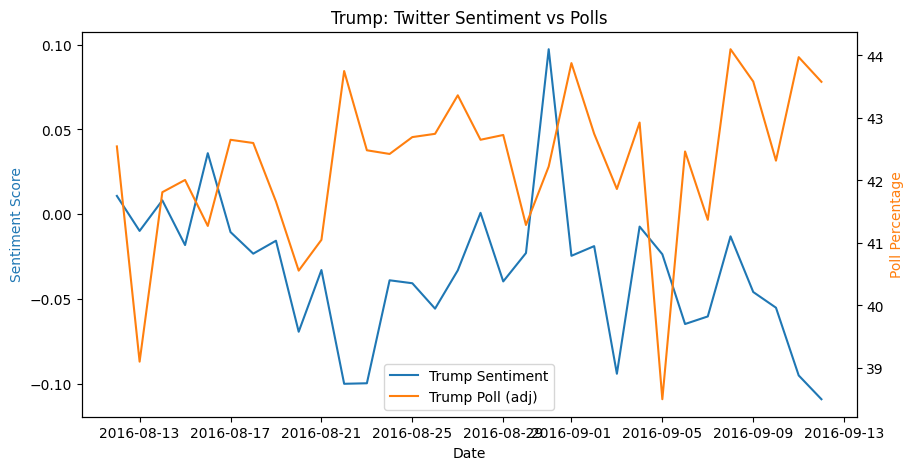

In [108]:
plt.figure(figsize=(10,5))

ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot Trump daily sentiment scores on the left axis (blue line)
ax1.plot(trump_merged['date'], trump_merged['predicted_sentiment'], color='tab:blue', label='Trump Sentiment')

# Plot Trump daily adjusted poll percentages on the right axis (orange line)
ax2.plot(trump_merged['date'], trump_merged['adjpoll_trump'], color='tab:orange', label='Trump Poll (adj)')

ax1.set_ylabel('Sentiment Score', color='tab:blue')
ax2.set_ylabel('Poll Percentage', color='tab:orange')
ax1.set_xlabel('Date')
plt.title('Trump: Twitter Sentiment vs Polls')

# Legends
ln1 = ax1.lines[0]
ln2 = ax2.lines[0]
plt.legend([ln1, ln2], ['Trump Sentiment', 'Trump Poll (adj)'], loc='lower center')

plt.show()




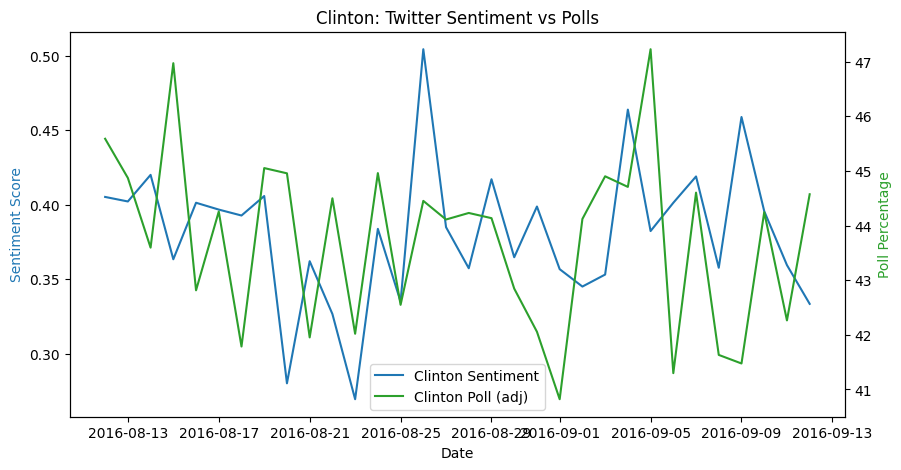

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

ax1 = plt.gca()
ax2 = ax1.twinx()

# Clinton Sentiment
ax1.plot(clinton_merged['date'], clinton_merged['predicted_sentiment'],
         color='tab:blue', label='Clinton Sentiment')
# Clinton Poll
ax2.plot(clinton_merged['date'], clinton_merged['adjpoll_clinton'],
         color='tab:green', label='Clinton Poll (adj)')

ax1.set_ylabel('Sentiment Score', color='tab:blue')
ax2.set_ylabel('Poll Percentage', color='tab:green')
ax1.set_xlabel('Date')
plt.title('Clinton: Twitter Sentiment vs Polls')

# Add legends
ln1 = ax1.lines[0]
ln2 = ax2.lines[0]
plt.legend([ln1, ln2], ['Clinton Sentiment', 'Clinton Poll (adj)'], loc='lower center')

plt.show()


# Topic Modelling for each Candidate
We also applied topic modeling separately to the Trump and Clinton tweet groups in order to identify the main topics of discussion associated with each candidate.



In [110]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def lda_topics(df, n_topics=5, n_words=10):
    # Join tokens into strings for LDA
    texts = df['tokens_normal'].apply(lambda x: ' '.join(x))
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    X = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)

    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"\nTopic {topic_idx+1}: ", end='')
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))

# Filter Clinton/Trump tweets
clinton_tweets = us_tweets[us_tweets['for_clinton']]
trump_tweets = us_tweets[us_tweets['for_trump']]

print("Clinton Tweet Topics:")
lda_topics(clinton_tweets, n_topics=5, n_words=10)

print("\nTrump Tweet Topics:")
lda_topics(trump_tweets, n_topics=5, n_words=10)



Clinton Tweet Topics:

Topic 1: hillary clinton hillaryclinton realdonaldtrump foundation money tax trump pay like

Topic 2: hillary realdonaldtrump clinton say cnn make news like look hillaryclinton

Topic 3: hillary realdonaldtrump clinton foxnews crooked hillaryclinton trump email medium cnn

Topic 4: hillary hillaryclinton realdonaldtrump clinton think obama vote want need liar

Topic 5: hillary realdonaldtrump clinton hillaryclinton imwithher vote trump lie neverhillary people

Trump Tweet Topics:

Topic 1: trump realdonaldtrump hillaryclinton vote say donald people win racist cnn

Topic 2: trump realdonaldtrump donald say nevertrump tax hillaryclinton think know like

Topic 3: trump realdonaldtrump mr america great maga president donald hillaryclinton make

Topic 4: trump realdonaldtrump hillaryclinton foxnews nevertrump imwithher say supporter new hrc

Topic 5: trump realdonaldtrump like mr nevertrump foxnews seanhannity kellyannepolls gop cnn


# Geographical Analysis of Twitter Sentiment
This allows us to observe the overall sentiment distribution and public opinion in the most active locations.

First, we analyze the sentiment of all tweets grouped by city, focusing on the cities with the highest tweet volumes.


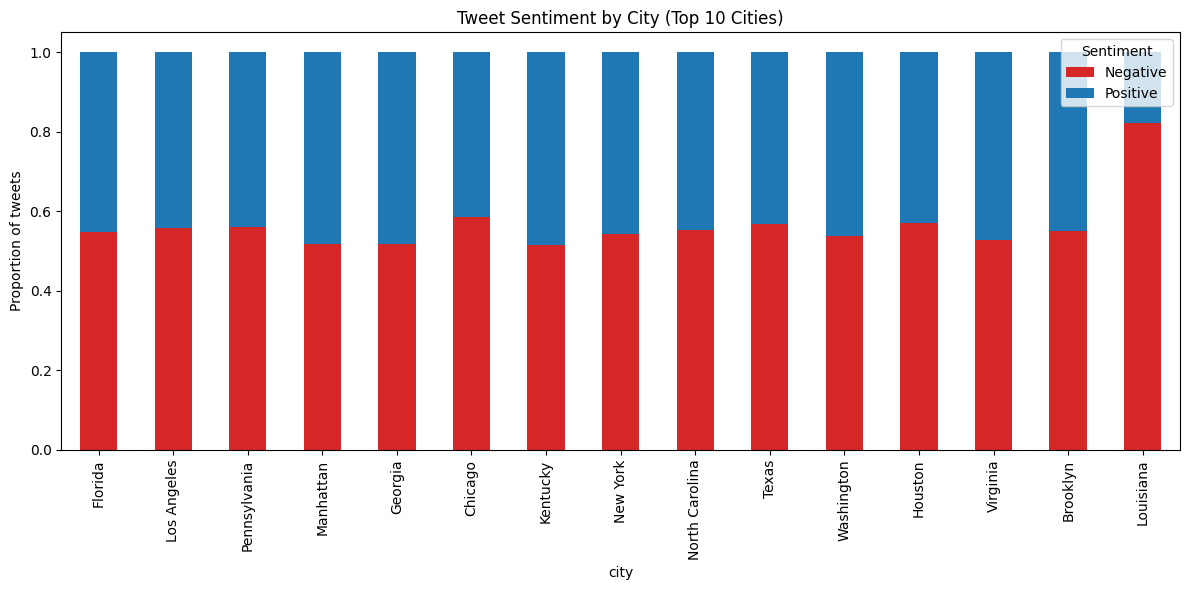

In [111]:
# We'll use 'city' and 'predicted_sentiment'
city_sentiment = us_tweets.groupby(['city', 'predicted_sentiment']).size().unstack(fill_value=0)

# Get only top 15 cities by total tweet count
top_cities = city_sentiment.sum(axis=1).sort_values(ascending=False).head(15).index
city_sentiment_top = city_sentiment.loc[top_cities]

# Normalize to proportion
city_sentiment_prop = city_sentiment_top.div(city_sentiment_top.sum(axis=1), axis=0)

# Plot
city_sentiment_prop.plot(kind='bar', stacked=True, figsize=(12,6), color=['tab:red', 'tab:blue'])
plt.ylabel("Proportion of tweets")
plt.title("Tweet Sentiment by City (Top 10 Cities)")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


Next, we separate the tweets into those related to Trump and those related to Clinton, and repeat the city-level sentiment analysis for each candidate. This reveals how sentiment varies by location for each individual candidate.

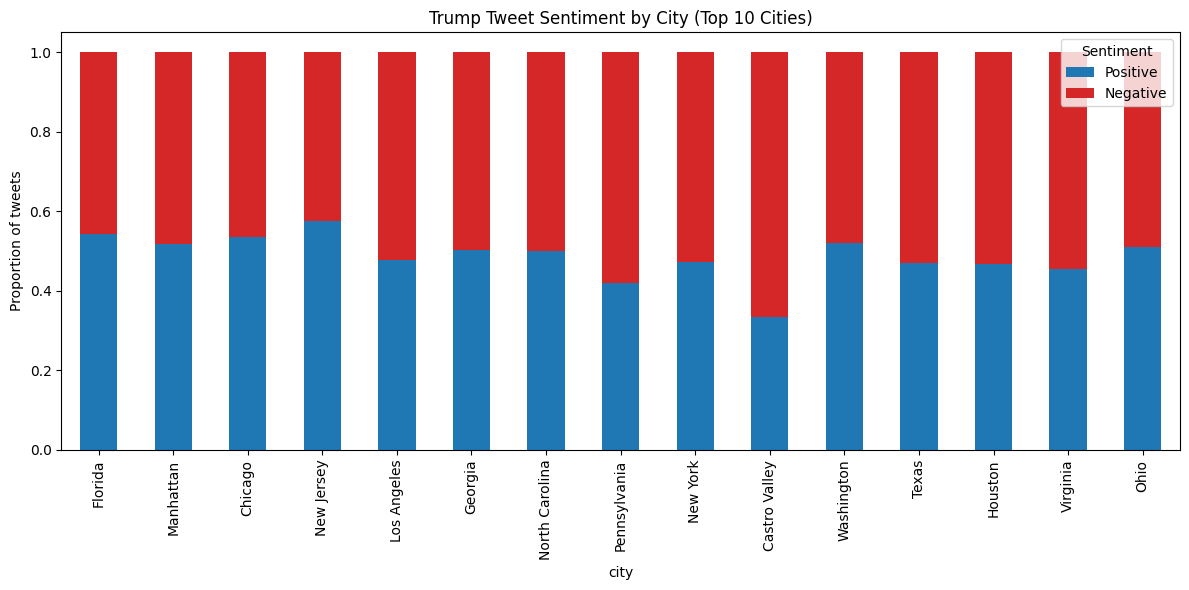

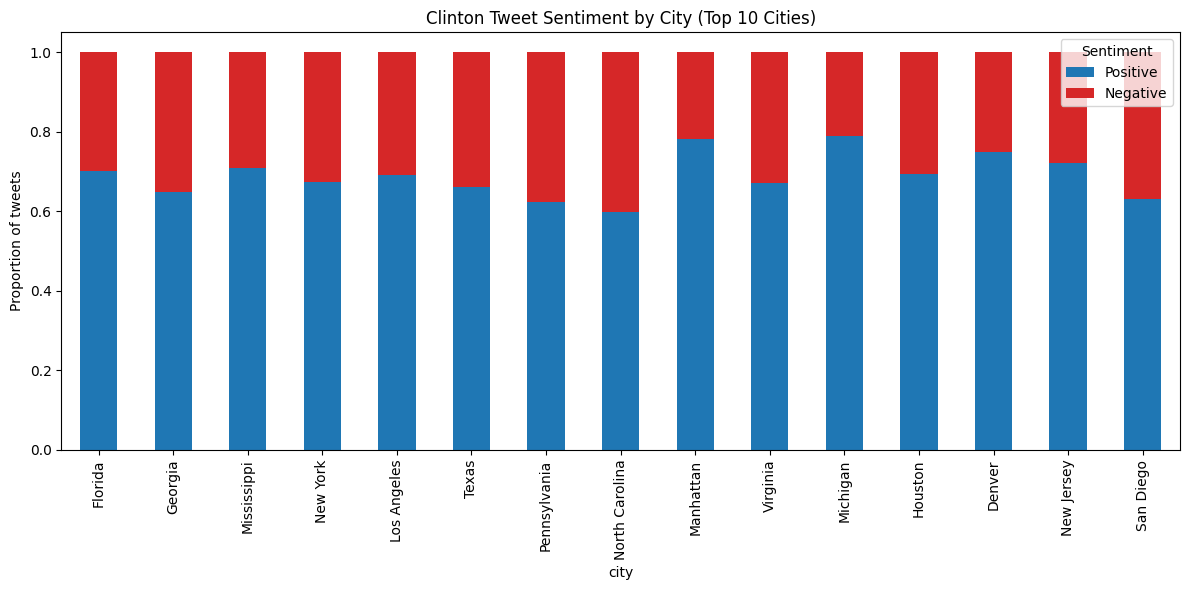

In [112]:
# Trump: Sentiment by City
trump_city_sentiment = trump_tweets.groupby(['city', 'predicted_sentiment']).size().unstack(fill_value=0)
top_trump_cities = trump_city_sentiment.sum(axis=1).sort_values(ascending=False).head(15).index
trump_city_sentiment_top = trump_city_sentiment.loc[top_trump_cities]
trump_city_sentiment_prop = trump_city_sentiment_top.div(trump_city_sentiment_top.sum(axis=1), axis=0)

# Ensure column order: Positive (blue), Negative (red)
trump_city_sentiment_prop = trump_city_sentiment_prop[['Positive', 'Negative']]

trump_city_sentiment_prop.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    color=['tab:blue', 'tab:red']
)
plt.ylabel("Proportion of tweets")
plt.title("Trump Tweet Sentiment by City (Top 10 Cities)")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# Clinton: Sentiment by City
clinton_city_sentiment = clinton_tweets.groupby(['city', 'predicted_sentiment']).size().unstack(fill_value=0)
top_clinton_cities = clinton_city_sentiment.sum(axis=1).sort_values(ascending=False).head(15).index
clinton_city_sentiment_top = clinton_city_sentiment.loc[top_clinton_cities]
clinton_city_sentiment_prop = clinton_city_sentiment_top.div(clinton_city_sentiment_top.sum(axis=1), axis=0)

# Ensure column order: Positive (blue), Negative (red)
clinton_city_sentiment_prop = clinton_city_sentiment_prop[['Positive', 'Negative']]

clinton_city_sentiment_prop.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    color=['tab:blue', 'tab:red']
)
plt.ylabel("Proportion of tweets")
plt.title("Clinton Tweet Sentiment by City (Top 10 Cities)")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()



Trump: Tweet Count by City


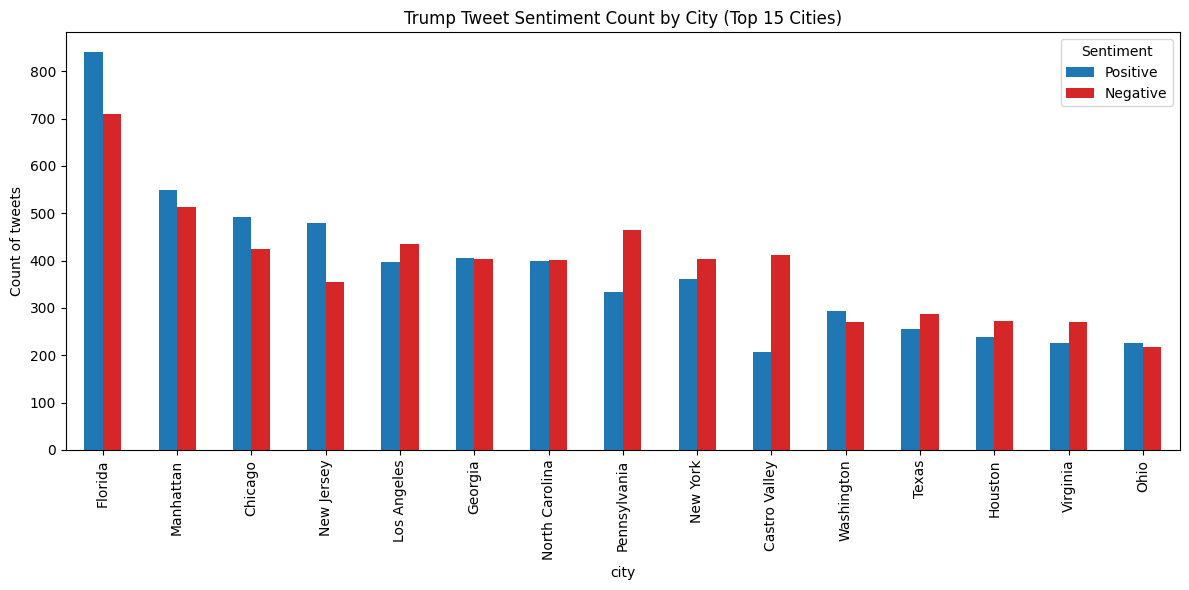

In [113]:
# Trump: Tweet Count by City
trump_city_sentiment = trump_tweets.groupby(['city', 'predicted_sentiment']).size().unstack(fill_value=0)
top_trump_cities = trump_city_sentiment.sum(axis=1).sort_values(ascending=False).head(15).index
trump_city_sentiment_top = trump_city_sentiment.loc[top_trump_cities]

# Ensure column order: Positive (blue), Negative (red)
trump_city_sentiment_top = trump_city_sentiment_top[['Positive', 'Negative']]

# Plot side-by-side bar plot (not stacked, for direct comparison)
trump_city_sentiment_top.plot(
    kind='bar',
    stacked=False,
    figsize=(12,6),
    color=['tab:blue', 'tab:red']
)
plt.ylabel("Count of tweets")
plt.title("Trump Tweet Sentiment Count by City (Top 15 Cities)")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()



Clinton: Tweet Count by City

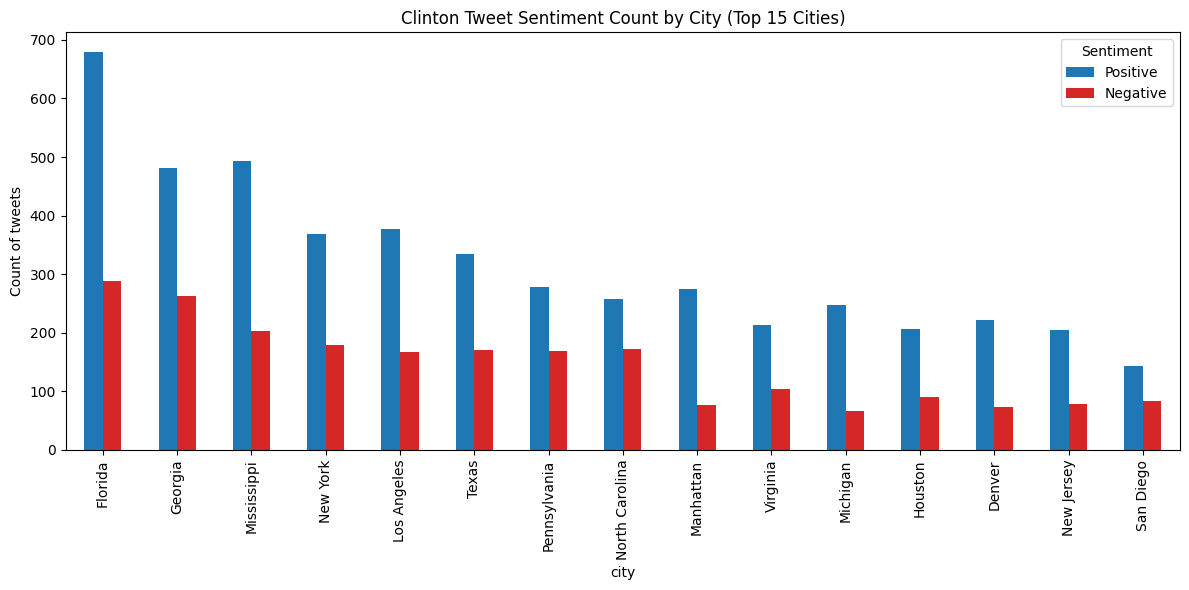

In [114]:
# Clinton: Tweet Count by City
clinton_city_sentiment = clinton_tweets.groupby(['city', 'predicted_sentiment']).size().unstack(fill_value=0)
top_clinton_cities = clinton_city_sentiment.sum(axis=1).sort_values(ascending=False).head(15).index
clinton_city_sentiment_top = clinton_city_sentiment.loc[top_clinton_cities]

# Ensure column order: Positive (blue), Negative (red)
clinton_city_sentiment_top = clinton_city_sentiment_top[['Positive', 'Negative']]

clinton_city_sentiment_top.plot(
    kind='bar',
    stacked=False,
    figsize=(12,6),
    color=['tab:blue', 'tab:red']
)
plt.ylabel("Count of tweets")
plt.title("Clinton Tweet Sentiment Count by City (Top 15 Cities)")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()
